In [1]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy        
import statsmodels


from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 999

sns.set()

plt.rcParams["figure.figsize"] = (10,7)

In [2]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sigmod_src.utils import read_json, pprint_json, path_from_spec_id, get_vector_for_spec_id
from sigmod_src.data.embedding import Embedder

# Load data

In [5]:
LABELS_PATH = '../data/raw/sigmod_medium_labelled_dataset.csv'

In [6]:
labels_df = pd.read_csv(LABELS_PATH)

In [7]:
labels_df.shape

(46665, 3)

In [8]:
labels_df.head()

,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


In [9]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46665 entries, 0 to 46664
Data columns (total 3 columns):
left_spec_id     46665 non-null object
right_spec_id    46665 non-null object
label            46665 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


# Load specs df

In [10]:
specs_df = pd.read_csv('../data/processed/specs_preprocessed.csv')
# specs_df.index=  specs_df.spec_id
specs_df.shape

(29771, 5)

In [11]:
specs_df[specs_df.page_title.isnull()]

,spec_id,page_title,page_title_stem,brand,site


In [12]:
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp,canon,www.ebay.com
1,www.ebay.com//60583,canon rebel 2000 35 mm great condition case,canon rebel 2000 35 mm great condit case,canon,www.ebay.com
2,www.ebay.com//60440,canon eos rebel t3i 18 55mm,canon eo rebel t3i 18 55mm,canon,www.ebay.com
3,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2,ge c1033 10 1 mp 3x zoom 2,ge,www.ebay.com
4,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp,vivitar,www.ebay.com


# Classes df

In [13]:
classes_df = pd.read_csv('../data/interim/classes.csv')
# classes_df.index = classes_df.spec_id
classes_df.head()

,spec_id,class_
0,buy.net//5641,0
1,www.ebay.com//58588,0
2,www.gosale.com//849,0
3,www.price-hunt.com//9794,0
4,buy.net//5698,1


## Add classes to specs

In [14]:
specs_df = specs_df.merge(classes_df, how='left')
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp,canon,www.ebay.com,NaN
1,www.ebay.com//60583,canon rebel 2000 35 mm great condition case,canon rebel 2000 35 mm great condit case,canon,www.ebay.com,NaN
2,www.ebay.com//60440,canon eos rebel t3i 18 55mm,canon eo rebel t3i 18 55mm,canon,www.ebay.com,NaN
3,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2,ge c1033 10 1 mp 3x zoom 2,ge,www.ebay.com,NaN
4,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp,vivitar,www.ebay.com,NaN


In [15]:
specs_df[specs_df.class_ == 0]

,spec_id,page_title,page_title_stem,brand,site,class_
1476,www.ebay.com//59612,excellent nikon d4 body 16 2 mp fx free,excel nikon d4 bodi 16 2 mp fx free,nikon,www.ebay.com,0.0
10648,www.ebay.com//58588,nikon d4 16 2 mp body,nikon d4 16 2 mp bodi,nikon,www.ebay.com,0.0
12740,www.ebay.com//54217,near mint nikon d4 body 16 2 mp fx,near mint nikon d4 bodi 16 2 mp fx,nikon,www.ebay.com,0.0
14506,www.price-hunt.com//9794,nikon d4 best india 2014,nikon d4 best india 2014,nikon,www.price-hunt.com,0.0
18853,buy.net//5641,nikon d4 body,nikon d4 bodi,nikon,buy.net,0.0
28521,www.gosale.com//849,nikon d4 cmos fx sale,nikon d4 cmos fx sale,nikon,www.gosale.com,0.0


In [16]:
labelled_specs_df = specs_df[~specs_df.class_.isnull()]

In [90]:
labelled_specs_df.to_csv('../data/interim/specs_df_labelled.csv', index=None)

# Triplet generator

In [17]:
labelled_specs_df['spec_idx'] = range(len(labelled_specs_df))
labelled_specs_df.head()

/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,spec_id,page_title,page_title_stem,brand,site,class_,spec_idx
46,www.ebay.com//41954,canon eos 20d 8 2 mp,canon eo 20d 8 2 mp,canon,www.ebay.com,6.0,0
120,www.ebay.com//48059,canon 20d 8 2 mp 28 80mm,canon 20d 8 2 mp 28 80mm,canon,www.ebay.com,6.0,1
146,www.ebay.com//47121,nikon d3200 24 2 mp kit,nikon d3200 24 2 mp kit,nikon,www.ebay.com,1.0,2
245,www.ebay.com//45559,nikon 1 j3 w vr 10 30mm,nikon 1 j3 w vr 10 30mm,nikon,www.ebay.com,7.0,3
256,www.ebay.com//58782,nikon d80 10 2 mp kit,nikon d80 10 2 mp kit,nikon,www.ebay.com,15.0,4


In [18]:
spec_lookup = labelled_specs_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()
spec_lookup[0]

[16, 143, 171, 196, 275, 294]

In [19]:
class_lookup = labelled_specs_df[~labelled_specs_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
class_lookup[143]

0.0

In [20]:
def gen_triplet(anchor_id,
               class_lookup_table,
               id_lookup_table
               ):
    anchor_class = class_lookup_table[anchor_id]
    positive_id = random.choice(list(set(id_lookup_table[anchor_class]).difference(set([anchor_id]))))
    
    negative_class = random.choice(list(set(id_lookup_table.keys()).difference([anchor_class])))
    negative_id = random.choice(id_lookup_table[negative_class])
    return (anchor_id, positive_id, negative_id)

In [21]:
labelled_specs_df.iloc[list(gen_triplet(0, class_lookup, spec_lookup))]

,spec_id,page_title,page_title_stem,brand,site,class_,spec_idx
46,www.ebay.com//41954,canon eos 20d 8 2 mp,canon eo 20d 8 2 mp,canon,www.ebay.com,6.0,0
11202,www.ebay.com//24608,canon eos 20d w bundle 3 batteries charger case,canon eo 20d w bundl 3 batteri charger case,ge,www.ebay.com,6.0,150
2902,www.ebay.com//42902,canon powershot elph sd30 ixus zoom 5,canon powershot elph sd30 ixus zoom 5,canon,www.ebay.com,24.0,31


# Triplet loss model

In [22]:
import torch
import torchtext
from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
from torch.utils.data.dataset import random_split
import torch.optim as optim

In [23]:
from torchtext.data import Field

In [24]:
from torchtext.data import Dataset, TabularDataset

In [48]:
tokenize = lambda x: x.split()
text_field = Field(sequential=True, tokenize=tokenize, lower=True)
brand_field = Field(sequential=False, use_vocab=True, lower=True)
site_field = Field(sequential=False, use_vocab=True, lower=True)

In [94]:
%%time
datafields = [("spec_id", None),
              ("page_title", None),
                 ("page_title_stem", text_field),
                  ("brand", brand_field),
                  ("site", site_field),
             ('class_', None)]

train_dataset = TabularDataset.splits(
        path="../data/interim/", # the root directory where the data lies
        train='specs_df_labelled.csv',
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=datafields)

train_dataset = train_dataset[0]

CPU times: user 6.38 ms, sys: 314 µs, total: 6.69 ms
Wall time: 6.33 ms


In [95]:
specs_df.head(1)

,spec_id,page_title,page_title_stem,brand,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp,canon,www.ebay.com,NaN


In [96]:
train_dataset.examples[0].__dict__

{'brand': 'canon',
 'page_title_stem': ['canon', 'eo', '20d', '8', '2', 'mp'],
 'site': 'www.ebay.com'}

In [153]:
train_dataset[gen_triplet(0, class_lookup, spec_lookup)[0]].__dict__, train_dataset[gen_triplet(0, class_lookup, spec_lookup)[2]].__dict__

({'brand': 'canon',
  'page_title_stem': ['canon', 'eo', '20d', '8', '2', 'mp'],
  'site': 'www.ebay.com'},
 {'brand': 'fujifilm',
  'page_title_stem': ['fujifilm',
   'sl300',
   'price',
   'shop',
   'comparison',
   'fujifilm'],
  'site': 'www.shopmania.in'})

In [154]:
%%time
text_field.build_vocab(train_dataset)
site_field.build_vocab(train_dataset)
brand_field.build_vocab(train_dataset)

CPU times: user 10.9 ms, sys: 453 µs, total: 11.3 ms
Wall time: 11.4 ms


In [155]:
text_field.vocab.freqs.most_common(10)

[('nikon', 202),
 ('mp', 117),
 ('bodi', 75),
 ('canon', 62),
 ('2', 61),
 ('d3200', 55),
 ('kit', 50),
 ('eo', 42),
 ('d7000', 39),
 ('3', 35)]

In [156]:
brand_field.vocab.freqs.most_common(10)

[('nikon', 200),
 ('canon', 59),
 ('sony', 30),
 ('fujifilm', 10),
 ('ge', 3),
 ('panasonic', 2),
 ('fuji', 2)]

In [157]:
train_dataset[0].page_title_stem

['canon', 'eo', '20d', '8', '2', 'mp']

In [394]:
class BiLSTMEmbedder(nn.Module):
    def __init__(self, hidden_dim, emb_dim=300,
                 spatial_dropout=0.05, recurrent_dropout=0.1, num_linear=1, num_lstm=1):
        super().__init__()
        self.embedding = nn.Embedding(len(text_field.vocab), emb_dim)
        self.encoder = nn.LSTM(emb_dim, hidden_dim, num_layers=num_lstm, 
                               dropout=recurrent_dropout)
        self.linear_layers = []
        for _ in range(num_linear - 1):
            self.linear_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.linear_layers = nn.ModuleList(self.linear_layers)
    
    def forward(self, seq):
        hdn, _ = self.encoder(self.embedding(seq))
        feature = hdn[-1, :, :]
        for layer in self.linear_layers:
            feature = layer(feature)
        return feature

In [395]:
emb_dim = 100
hidden_dim = 300
num_linear = 3
num_lstm = 1
model = BiLSTMEmbedder(hidden_dim, emb_dim=emb_dim, num_linear=num_linear, num_lstm=num_lstm)

model

/home/boris/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


BiLSTMEmbedder(
  (embedding): Embedding(279, 100)
  (encoder): LSTM(100, 300, dropout=0.1)
  (linear_layers): ModuleList(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=300, bias=True)
  )
)

In [396]:
from torchtext.data import Iterator
train_iter = Iterator(train_dataset, batch_size=1)
train_iter.init_epoch()
next(train_iter.__iter__())


[torchtext.data.batch.Batch of size 1]
	[.page_title_stem]:[torch.LongTensor of size 5x1]
	[.brand]:[torch.LongTensor of size 1]
	[.site]:[torch.LongTensor of size 1]

In [397]:
train_dataset[0].page_title_stem

['canon', 'eo', '20d', '8', '2', 'mp']

In [398]:
def triplet_iterator(dataset):
    shuffled_idx = list(range(len(dataset)))
    np.random.shuffle(shuffled_idx)
    
    for i in shuffled_idx:
        _, pos_idx, neg_idx = gen_triplet(i, class_lookup, spec_lookup)
        
        triplet = [train_dataset[i].page_title_stem, 
                   train_dataset[pos_idx].page_title_stem,
                   train_dataset[neg_idx].page_title_stem]
        triplet = text_field.pad(triplet)
        triplet = text_field.numericalize(triplet[:3])
        yield triplet
        
next(iter(triplet_iterator(train_dataset)))

tensor([[ 12,  12,   2],
        [ 76,  80,  14],
        [ 82, 153,  20],
        [ 87,   1,  11],
        [149,   1,   3],
        [ 53,   1,   4],
        [ 77,   1,   1],
        [ 80,   1,   1],
        [ 63,   1,   1]])

In [399]:
text_field.numericalize([train_dataset[0].page_title_stem])

tensor([[ 5],
        [ 9],
        [35],
        [30],
        [ 6],
        [ 3]])

In [400]:
train_dataset[0].page_title_stem

['canon', 'eo', '20d', '8', '2', 'mp']

In [401]:
model.forward(next(train_iter.__iter__()).page_title_stem)

tensor([[ 0.0555,  0.0136, -0.0190, -0.0101, -0.0283,  0.0784,  0.0644, -0.0249,
         -0.0934, -0.0023, -0.0047, -0.0622, -0.0431, -0.0289,  0.0508, -0.0608,
          0.0504,  0.0581, -0.0300,  0.0631,  0.0193, -0.0021, -0.0625, -0.0515,
          0.0024,  0.0094, -0.0095,  0.0584,  0.0230,  0.0569, -0.0551,  0.0003,
          0.0894,  0.0150,  0.0194, -0.0545,  0.0340,  0.0701,  0.0064,  0.0254,
         -0.0063,  0.0417,  0.0436,  0.0113, -0.0244,  0.0069, -0.0447, -0.0123,
         -0.0171,  0.0463, -0.0108, -0.0219, -0.0086,  0.0781,  0.0105,  0.0318,
         -0.0127,  0.0535,  0.0617,  0.0443, -0.0475,  0.0435,  0.0513,  0.0263,
         -0.0565, -0.0409, -0.0347, -0.0227, -0.0141, -0.0900,  0.0110, -0.0212,
         -0.0555, -0.0189, -0.0126,  0.0427, -0.0652,  0.0028, -0.0603,  0.0351,
          0.0818, -0.0154, -0.0462,  0.0005, -0.0049, -0.0422,  0.0329, -0.0168,
         -0.0810,  0.0027, -0.0451,  0.0006, -0.0486, -0.0279,  0.0474,  0.1304,
         -0.0339,  0.0120, -

In [402]:
def triplet_loss(anchor, pos, neg, margin=1):
    return torch.clamp(F.cosine_similarity(anchor, pos, dim=0) - F.cosine_similarity(anchor, neg, dim=0) + margin, min=0)

In [403]:
loss_history = []

In [404]:
opt = optim.Adam(model.parameters(), lr=1e-3)
epochs = 30

In [405]:
%%time
for epoch in range(1, epochs + 1):
    model.train()
    
    running_loss = 0
    count_triplets = 0
    
    for triplet in tqdm(iter(triplet_iterator(train_dataset))):
        opt.zero_grad()
        
        embeddings = model(triplet)
        loss = triplet_loss(embeddings[0], embeddings[1], embeddings[2])
        loss.backward()
        opt.step()
        
        running_loss += loss.data
        count_triplets +=1 
        
    epoch_loss = running_loss / count_triplets
    loss_history.append(epoch_loss)
    
    print('Epoch: {}, Training Loss: {:.4f}'.format(epoch, epoch_loss))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 1, Training Loss: 1.0194


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 2, Training Loss: 0.9988


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 3, Training Loss: 0.9969


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 4, Training Loss: 0.9980


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 5, Training Loss: 0.9913


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 6, Training Loss: 0.8731


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 7, Training Loss: 0.8376


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 8, Training Loss: 0.9326


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 9, Training Loss: 0.8795


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 10, Training Loss: 0.8981


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 11, Training Loss: 0.8526


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 12, Training Loss: 0.9077


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 13, Training Loss: 0.9241


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 14, Training Loss: 0.8961


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 15, Training Loss: 0.8640


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 16, Training Loss: 0.9650


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 17, Training Loss: 0.9487


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 18, Training Loss: 0.8867


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 19, Training Loss: 0.9218


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 20, Training Loss: 0.9165


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 21, Training Loss: 0.8630


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 22, Training Loss: 0.8769


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 23, Training Loss: 0.8551


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 24, Training Loss: 0.8238


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 25, Training Loss: 0.8589


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 26, Training Loss: 0.8075


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 27, Training Loss: 0.8527


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 28, Training Loss: 0.8272


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 29, Training Loss: 0.8361


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 30, Training Loss: 0.8153
CPU times: user 6min 34s, sys: 1min 49s, total: 8min 24s
Wall time: 2min 55s


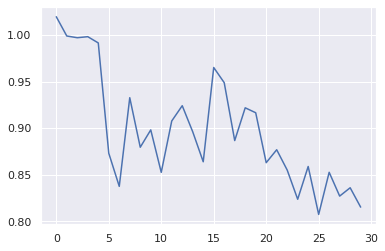

In [407]:
plt.figure()
plt.plot(loss_history, label='loss')
plt.show()

# Produce embeddings and TSNE

In [408]:
embeddings = []
for ex in tqdm(train_dataset):
    emb = np.array(model(text_field.numericalize([ex.page_title_stem]))[0].data)
    embeddings.append(emb)
embeddings = np.array(embeddings)

HBox(children=(IntProgress(value=0, max=306), HTML(value='')))

In [409]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [410]:
tsne = TSNE(
    n_components=2,
    metric='cosine',
    n_jobs=3,
    verbose=True,
)

In [411]:
emb_ld = tsne.fit_transform(embeddings)

In [412]:
emb_ld.shape

(306, 2)

In [413]:
labelled_spec_classes = labelled_specs_df.class_
labelled_spec_classes = labelled_spec_classes.reset_index()
labelled_spec_classes.shape

(306, 2)

In [414]:
labelled_spec_classes.head()

,index,class_
0,46,6.0
1,120,6.0
2,146,1.0
3,245,7.0
4,256,15.0


In [415]:
emb_tdf = pd.DataFrame(emb_ld)
emb_tdf = pd.concat([emb_tdf, labelled_spec_classes], axis=1, ignore_index=True)
emb_tdf.columns = ['x', 'y', 'original_index', 'class_']
emb_tdf.head()

,x,y,original_index,class_
0,-14.429012,1.339705,46,6.0
1,-15.011489,-1.327426,120,6.0
2,-7.727797,-2.376779,146,1.0
3,16.836557,4.149791,245,7.0
4,-6.870190,-1.854373,256,15.0


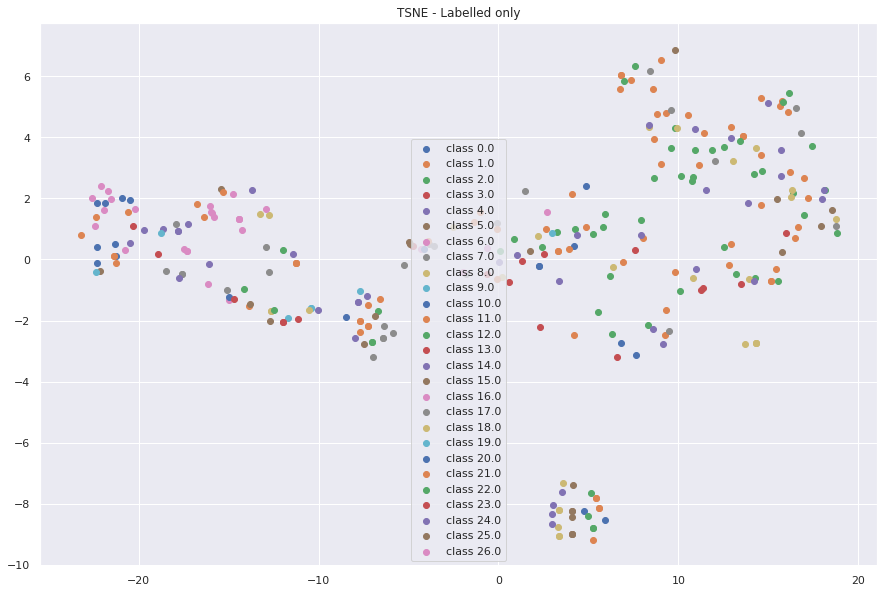

In [416]:
plt.figure(figsize=(15, 10))
plt.title('TSNE - Labelled only')
for class_ in emb_tdf['class_'].sort_values().unique():
    class_ld_df = emb_tdf[emb_tdf.class_==class_]
    plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class {class_}')

plt.legend()
plt.show()